# Convolutional neural network for classifying Root data fits.


Here, we define, train, and save new convolutional models as well as some 
simple model evaluation. We define hyper-parameters, number of layers, and 
training and testing datasets. 

Here, at the final layer, the network takes into account chi squared per degree of freedom.

#### Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json
from keras.layers import concatenate, Lambda

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils as utils

%matplotlib inline

Using TensorFlow backend.


#### Load root fit data from file

In [4]:
# Define image file path
im_path="/media/brady/4be7777f-c84c-40ca-af3a-b8c6e4f2f90d/brady/Projects/fit_pmt/images/png_fit_nn/"

# Load dataset
x, y, params = utils.load_dataset_all(im_dir="train", log=False, im_path=im_path)
x_dev, y_dev, params_dev = utils.load_dataset_all(im_dir="dev", log=False, im_path=im_path)

# Grab dimensions of picture
(m, h, w, c) = x.shape
m_dev = x_dev.shape[0]
input_shape = h, w, c
num_params = params.shape[1]

# Print dimensions
print("(m, height, width, channels): (" + str(m) + ", " + str(h) + ", " + str(w) + ", " + str(c) + ")")
print("m_dev: " + str(m_dev))
print("y: " + str(y.shape))
print("params: " + str(params.shape))


(m, height, width, channels): (1396, 236, 348, 3)
m_dev: 129
y: (1396, 1)
params: (1396, 54)


label: good
label: [1]
params: [ 0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  2.000000e+01
  5.000000e-02  6.144692e+02  2.252700e+00  1.000000e-02  2.560000e+00
  4.000000e+00  2.252700e+00  5.000000e-01  5.000000e-01  1.000000e-03
 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
 -1.000000e+00  0.000000e+00  0.000000e+00  5.000000e-01 -1.000000e+00
 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
  1.000000e+00  1.000000e+00  6.400000e-03  6.130692e+02  1.706800e+00
  5.000000e-02  5.411800e+00  1.132900e+00  1.556800e+00  1.765000e-01
  8.235000e-01  2.000000e-04  1.620000e-02  1.270000e-02  1.000000e-03
  8.910000e-02  1.870000e-02  1.070000e-02  2.800000e-03  3.000000e-03
  6.254000e+00  1.768000e-01  7.300000e-03  4.130900e+00]


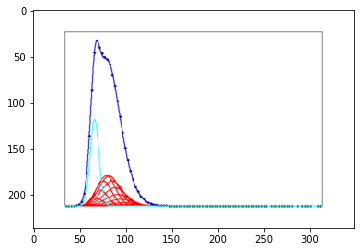

In [5]:
# Print an image
index = 420
this_image = x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
print("params: " + str(params[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Define and Train multi-layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

##### Define hyperparameters

In [8]:
# Initialize
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(32)
kernels.append(5)
strides.append(2)
pools.append(2)
dropouts.append(0.4)

# Conv2
filters.append(128)
kernels.append(5)
strides.append(2)
pools.append(2)
dropouts.append(0.3)

# Conv3
filters.append(256)
kernels.append(4)
strides.append(2)
pools.append(2)
dropouts.append(0.2)

# Define dense (fully-connected) layer sizes
fc1 = 20
fc2 = 10

##### Define keras layers (model)

In [9]:
def concat_params(input):
    a = input[0]
    b = input[1]
    return concatenate([a,b], axis=1)

In [15]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Define additional input info
Params = Input(shape=(num_params,), name='Params')

# Initialize activation as input
a = X
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    # Activate
    a = Activation('relu', name=('a' + str(i)))(a)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)

# Flatten output of convNet
a = Flatten()(a)
# Define first fully connected layer
a = Dense(units=fc1, activation='relu', name='fc0')(a)
# Use some dropout here for regularization
a = Dropout(rate=0.2)(a)

# Activate parameters
a_params = Activation('tanh', name='param_act')(Params)

# Concatenate parameters to activations
a = Lambda(concat_params, name='concat_params')([a, a_params])

# Define second fully connected layer
a = Dense(units=fc2, activation='relu', name='fc1')(a)
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=[X, Params], outputs=a)

##### Define optimizer, loss, and metrics. Compile model.

In [16]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 116, 172, 32) 2432        Input[0][0]                      
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 116, 172, 32) 128         conv0[0][0]                      
__________________________________________________________________________________________________
a0 (Activation)                 (None, 116, 172, 32) 0           bn0[0][0]                        
__________________________________________________________________________________________________
max_pool0 

##### Fit the model to the data (train)

In [ ]:
# Now, fit the model to the data
history = model.fit([x, params], y, validation_data=([x_dev, params_dev], y_dev), epochs=400, batch_size=128)

# List all data in history
print(history.history.keys())
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 1396 samples, validate on 129 samples
Epoch 1/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1283 - acc: 0.8216 - val_loss: 0.1437 - val_acc: 0.7829
Epoch 2/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1280 - acc: 0.8181 - val_loss: 0.1452 - val_acc: 0.7752
Epoch 3/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1253 - acc: 0.8352 - val_loss: 0.1459 - val_acc: 0.7752
Epoch 4/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1236 - acc: 0.8374 - val_loss: 0.1428 - val_acc: 0.7907
Epoch 5/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1245 - acc: 0.8352 - val_loss: 0.1447 - val_acc: 0.7829
Epoch 6/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1244 - acc: 0.8345 - val_loss: 0.1446 - val_acc: 0.7829
Epoch 7/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1263 - acc: 0.8238 - val_loss: 0.1431 - val_acc: 0.7829
Epoch 8/

Epoch 61/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1023 - acc: 0.8539 - val_loss: 0.1290 - val_acc: 0.8062
Epoch 62/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0992 - acc: 0.8689 - val_loss: 0.1345 - val_acc: 0.8062
Epoch 63/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1015 - acc: 0.8596 - val_loss: 0.1305 - val_acc: 0.8062
Epoch 64/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1003 - acc: 0.8668 - val_loss: 0.1315 - val_acc: 0.8062
Epoch 65/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1025 - acc: 0.8610 - val_loss: 0.1335 - val_acc: 0.7907
Epoch 66/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1017 - acc: 0.8596 - val_loss: 0.1366 - val_acc: 0.7907
Epoch 67/400
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0998 - acc: 0.8725 - val_loss: 0.1374 - val_acc: 0.7907
Epoch 68/400
1396/1396 [========================

##### Load pretrained conv model

In [47]:
# load json and create model
json_file = open('trained/conv_model_quickngood.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_quickngood.h5")
print("Loaded model from disk")

Loaded model from disk


##### Additional model evaluation

In [8]:
# Evaluate model, get metrics back
stats = model.evaluate([x_dev, params_dev], y_dev)
# Calculate predictions vector from model
predictions = model.predict(x_dev)
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_dev
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

69/69 [==============================] - 0s 4ms/step

Performance on VALIDATION set
.............................
Loss: 0.098587359104346
Accuracy: 0.8985507246376812
Precision: 0.9555555555555556
Recall: 0.8958333333333334
.............................
List of indices of wrong guesses:
[5, 7, 13, 42, 48, 52, 53]


##### Look at an image

label: [0]
prediction: [0.]
(236, 348, 3)


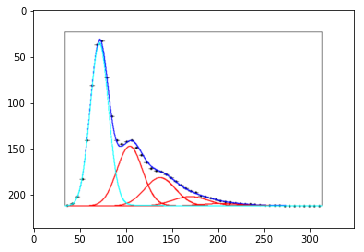

In [9]:
# Choose an index 
index = 58

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

##### Save convolutional model to disc

In [65]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_model_chi_500epoch.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_model_chi_500epoch.h5")
print("Saved model to disk")

Saved model to disk
